# RAFT IVF Flat

## Introduction

This notebook demonstrates how to run approximate nearest neighbor search using the IVF-Flat algorithm.

In [37]:
import os
import cupy as cp
import numpy as np
from pylibraft.common import DeviceResources
from pylibraft.neighbors import ivf_flat
import time
import matplotlib.pyplot as plt

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
mr = rmm.mr.PoolMemoryResource(
     rmm.mr.CudaMemoryResource(),
     initial_pool_size=2**30
)
rmm.mr.set_current_device_resource(mr)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [ ]:
# Report the GPU in us
!nvidia-smi

### Utility functions

In [29]:
def memmap_bin_file(bin_file, dtype, shape=None):
    if bin_file is None:
        return None
    a = np.memmap(bin_file, mode="r", dtype="uint32", shape=(2,))
    if shape is None:
        shape = (a[0], a[1])
    # print('# {}: shape: {}, dtype: {}'.format(bin_file, shape, dtype))
    return np.memmap(bin_file, mode="r", dtype=dtype, offset=8, shape=shape)


def calc_recall(ann_idx, true_nn_idx):
    ann_idx = np.asarray(ann_idx)
    if ann_idx.shape != true_nn_idx.shape:
        raise RuntimeError(
            "Incompatible shapes {} vs {}".format(ann_idx.shape, true_nn_idx.shape)
        )
    n = 0
    for i in range(ann_idx.shape[0]):
        n += np.intersect1d(ann_idx[i, :], true_nn_idx[i, :]).size
    recall = n / ann_idx.size
    return recall

class BenchmarkTimer:
    """Provides a context manager that runs a code block `reps` times
    and records results to the instance variable `timings`. Use like:
    .. code-block:: python
        timer = BenchmarkTimer(rep=5)
        for _ in timer.benchmark_runs():
            ... do something ...
        print(np.min(timer.timings))

        This class is part of the rapids/cuml benchmark suite
    """

    def __init__(self, reps=1, warmup=0):
        self.warmup = warmup
        self.reps = reps
        self.timings = []

    def benchmark_runs(self):
        for r in range(self.reps + self.warmup):
            t0 = time.time()
            yield r
            t1 = time.time()
            self.timings.append(t1 - t0)
            if r >= self.warmup:
                self.timings.append(t1 - t0)

## Load dataset

In [4]:
# TODO use a smaller dataset and dataset loader
k = 10

dtype=np.float32

dataset_dirname = "/workspace/rapids/gh/data/deep-1B"

dataset_filename = os.path.join(dataset_dirname, "base.10M.fbin")
queries_filename = os.path.join(dataset_dirname, "query.public.10K.fbin")

# groundthruth filenames
dataset_dirname = "/workspace/rapids/gh/data/deep-10M"
gt_indices_filename = os.path.join(dataset_dirname, "groundtruth.neighbors.ibin")
gt_dist_filename = os.path.join(dataset_dirname, "groundtruth.distances.fbin")

dataset_np = memmap_bin_file(dataset_filename, dtype)
dataset = cp.asarray(dataset_np)

n_samples = dataset.shape[0]
n_features = dataset.shape[1]

queries = np.asarray(memmap_bin_file(queries_filename, dtype))

gt_indices_100 = memmap_bin_file(gt_indices_filename, dtype=np.int32)
gt_distances_100 = memmap_bin_file(gt_dist_filename, dtype=np.float32)

In [5]:
itemsize = np.dtype(dtype).itemsize 
total_size = n_samples * n_features * itemsize / (1<<30)
print("Dataset shape=({0},{1}), dtype={2}, size={3:6.1f} GiB".format(n_samples, n_features, dtype, total_size))

Dataset shape=(10000000,96), dtype=<class 'numpy.float32'>, size=   3.6 GiB


In [6]:
# we need only k columns from the groundthruth files
gt_indices = np.asarray(gt_indices_100[:, :k])
gt_distances = np.asarray(gt_distances_100[:, :k])

## Build index

In [7]:
%%time
#handle = Handle()

# see documentation https://github.com/rapidsai/raft/blob/082be6ecd4437d180bf34d5ba5d691a27b21141f/python/pylibraft/pylibraft/neighbors/ivf_flat/ivf_flat.pyx#L77-L124
build_params = ivf_flat.IndexParams(
        n_lists=1024,
        metric="sqeuclidean",
        kmeans_trainset_fraction=0.1,
        kmeans_n_iters=20,
        add_data_on_build=True
    )

index = ivf_flat.build(build_params, dataset)#, handle=handle)

CPU times: user 315 ms, sys: 21.9 ms, total: 337 ms
Wall time: 334 ms


The index is built. We can print some basic information of the index

In [24]:
print(index)

Index(type=IVF-FLAT, metric=sqeuclidean, size=10000000, dim=96, n_lists=1024, adaptive_centers=False)


## Search neighbors

In [8]:
queries.shape

(10000, 96)

In [9]:
handle = DeviceResources()

In [18]:
%%time
n_queries=10000
handle = DeviceResources()
# n_probes is the number of clusters we select in the first (coarse) search step. This is the only hyper parameter for search.
search_params = ivf_flat.SearchParams(n_probes=50)

# Search 10 nearest neighbors.
distances, indices = ivf_flat.search(search_params, index, cp.asarray(queries[:n_queries,:]), k=10, handle=handle)
    
handle.sync()
distances, neighbors = cp.asnumpy(distances), cp.asnumpy(indices)

CPU times: user 386 ms, sys: 209 ms, total: 594 ms
Wall time: 590 ms


The returnad arrays have shappe {n_queries x 10] and store the distance values and the indices of the searched vectors.

In [19]:
calc_recall(neighbors, gt_indices)

0.99419

## Save and load the index

In [20]:
ivf_flat.save("my_ivf_flat_index.bin", index)

In [21]:
index = ivf_flat.load("my_ivf_flat_index.bin")

## Tune search parameters
Search has a single hyper parameter: n_probes, which describes how many neighboring cluster is searched (probed) for each query. Within a probed cluster, we compute the distance between all the vectors in the cluster and the query point, and select the top-k neighbors. Finally, we consider all the neighbor candidates from the probed clusters, and select top-k out of them.

Index(type=IVF-FLAT, metric=sqeuclidean, size=10000000, dim=96, n_lists=1024, adaptive_centers=False)


In [42]:
n_probes = np.asarray([10, 50, 100, 200, 500, 1000]);
qps = np.zeros(n_probes.shape);
recall = np.zeros(n_probes.shape);

for i in range(len(n_probes)):
    print("\nBenchmarking search with n_probes=", n_probes[i])
    timer = BenchmarkTimer(reps=1, warmup=1)
    for rep in timer.benchmark_runs():
        distances, neighbors = ivf_flat.search(
            ivf_flat.SearchParams(n_probes=n_probes[i]),
            index,
            cp.asarray(queries),
            k,
            handle=handle,
        )
    
    recall[i] = calc_recall(cp.asnumpy(neighbors), gt_indices)
    print("recall", recall[i])

    timings = np.asarray(timer.timings)
    avg_time = timings.mean()
    std_time = timings.std()
    qps[i] = queries.shape[0] / avg_time
    print("Average search time: {0:7.3f} +/- {1:7.3} s".format(avg_time, std_time))
    print("Queries per second (QPS): {0:8.0f}".format(qps[i]))


Benchmarking search with n_probes= 10
recall 0.93047
Average search time:   0.081 +/-  0.0559 s
Queries per second (QPS):   123637

Benchmarking search with n_probes= 50
recall 0.99419
Average search time:   0.391 +/-   0.276 s
Queries per second (QPS):    25587

Benchmarking search with n_probes= 100
recall 0.99842
Average search time:   0.774 +/-   0.546 s
Queries per second (QPS):    12927

Benchmarking search with n_probes= 200
recall 0.99941
Average search time:   1.521 +/-    1.07 s
Queries per second (QPS):     6575

Benchmarking search with n_probes= 500
recall 0.99956
Average search time:   3.756 +/-    2.66 s
Queries per second (QPS):     2662

Benchmarking search with n_probes= 1000
recall 0.99957
Average search time:   6.897 +/-    4.88 s
Queries per second (QPS):     1450


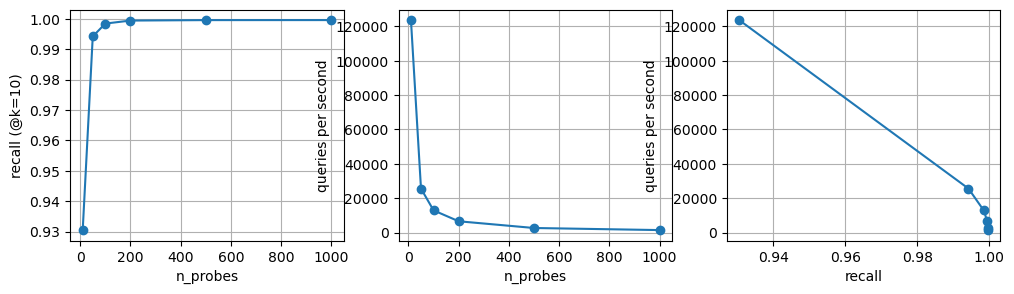

In [53]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax.plot(n_probes, recall,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('n_probes')
ax.grid()
ax.set_ylabel('recall (@k=10)')

ax = fig.add_subplot(132)
ax.plot(n_probes, qps,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('n_probes')
ax.grid()
ax.set_ylabel('queries per second');

ax = fig.add_subplot(133)
ax.plot(recall, qps,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('recall')
ax.grid()
ax.set_ylabel('queries per second');
#ax.set_yscale('log')

## Adjust build parameters
### n_clusters

### trainset fraction

### add vectors on build
Currently we cannot configure how RAFT sub-samples the input. If we want to have a fine control on how we select the training set, then we can create the index in two steps:
1. Define cluster centers on a training set, but do not add any vector to the index
2. add vectors to the index (extend)

- The second step is familiar for faiss users.
- Note that raft does not require adding the data in batches. We do internal batching. If the user prefers, can use your own batching.
- We have an option in controlling whether the cluster centers should be recalculated.


In [54]:
build_params = ivf_flat.IndexParams(
        n_lists=1024,
        metric="sqeuclidean",
        kmeans_trainset_fraction=1,
        kmeans_n_iters=20,
        add_data_on_build=False
    )

n_train = 10000
train_set = dataset[cp.random.choice(dataset.shape[0], n_train, replace=False),:]
index = ivf_flat.build(build_params, train_set)
ivf_flat.extend(index, dataset, cp.arange(dataset.shape[0], dtype=cp.int64))

Index(type=IVF-FLAT, metric=sqeuclidean, size=10000000, dim=96, n_lists=1024, adaptive_centers=False)

In [55]:
index.size

10000000